In [1]:
import google.cloud.bigquery as bq
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.dpi']= 360

In [3]:
%matplotlib inline
%load_ext google.cloud.bigquery

Extract hurricane observation records for :
* The North Atlantic basin
* Where there is available wind speed measurement
* After 1966 (the first satellite observation of a huricane)

Find the max classification of each hurricane by the [Saffir Simpson](https://en.wikipedia.org/wiki/Saffir%E2%80%93Simpson_scale) scale.

In [4]:
%%bigquery hrcn

SELECT
  CAST(season AS INT64) AS season_int,
  sid,
  max(USA_SSHS) category
FROM
  `bigquery-public-data.noaa_hurricanes.hurricanes`
WHERE
  basin = "NA"
  AND USA_SSHS IS NOT NULL
  AND USA_SSHS >= 1
  AND CAST(season AS INT64) > 1966
GROUP BY
  season_int, sid

In [20]:
decade_bins = list(range(1850, 2030, 10))

hrcn['decade'] = pd.cut(x=hrcn.season_int, bins=decade_bins, labels=decade_bins[1:]).astype(int)

In [32]:
hrcn_pivot_decade = pd.pivot_table(data=hrcn,
                                   index='decade',
                                   columns='category',
                                   values='sid',
                                   aggfunc='count',
                                   fill_value=0)

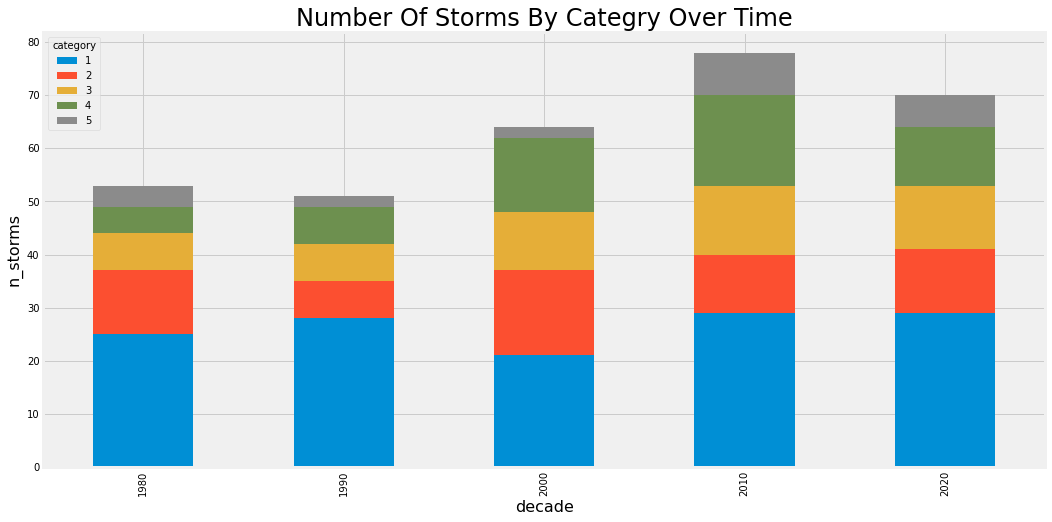

In [33]:
hrcn_pivot_decade.loc[1980:].plot.bar(stacked=True,figsize=(16, 8))

plt.title('Number Of Storms By Categry Over Time', size=24)
plt.ylabel('n_storms', size=16)
plt.xlabel('decade', size=16)
plt.show()